In [1]:

# %matplotlib inline
import math
from math import atan2, pi, sqrt, floor
from cmath import exp
import numpy as np
import kwant
import scipy.sparse.linalg as sla
from matplotlib import pyplot
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
from pylab import rcParams
#%matplotlib notebook
from pylab import *

plt.rcParams['figure.figsize'] = [8, 15]

In [2]:
# Physical constants

h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

#### Scaling:
# density:  n = (E/at)^2 * 8/(9*pi)

In [3]:
W=1200
L=2500
w=120
s=2
shift = 500

In [4]:
def rectangular(pos):
    x, y = pos
    return abs(x) < L and abs(y) < W

In [5]:
def QPC_tri(pos):
    l = abs((W-w)/s)
    x, y = pos
    if -l <= x-shift <= l:
        return abs(x-shift) <= l and abs(y) < w + s*abs(x-shift)
    else: 
        return abs(x) < L and abs(y) < W

In [6]:
def make_system(a=10,t=1.0):
    graphene = kwant.lattice.honeycomb(a,norbs=1)
    a, b = graphene.sublattices
    sys = kwant.Builder()
 
    def lead0_shape(pos):
        x, y = pos
        return -W  < y < W

    def lead1_shape(pos):
        x, y = pos
        return -W <  y < W

    def onsite(site,Vtip,xtip,ytip,Rtip):
        x, y = site.pos
        return Vtip /(1+((x-xtip)**2+(y-ytip)**2)/Rtip**2)
    
    sys[graphene.shape(QPC_tri, (0,0))] = onsite
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -t

    sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[graphene.shape(lead0_shape, (0, 0))] =  0
    lead0[graphene.neighbors()]= -t
    sys.attach_lead(lead0)

    
    sym1 = kwant.TranslationalSymmetry(graphene.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lead1_shape, (0, 0))] =  0
    lead1[graphene.neighbors()]=-t
    sys.attach_lead(lead1)


    return sys

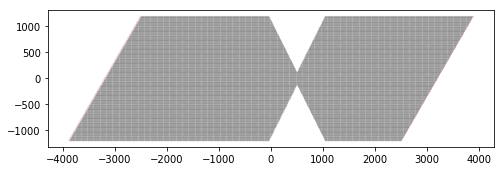

In [7]:
sys = make_system()

# Check that the system looks as intended.
kwant.plot(sys)
#     plt.show()

# Finalize the system.
syst = sys.finalized()


In [8]:
def onsite(site,Vtip,xtip,ytip,Rtip):
    x, y = site.pos
    return Vtip /(1+((x-xtip)**2+(y-ytip)**2)/Rtip**2)

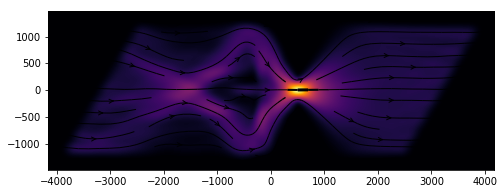

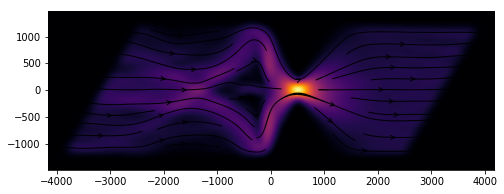

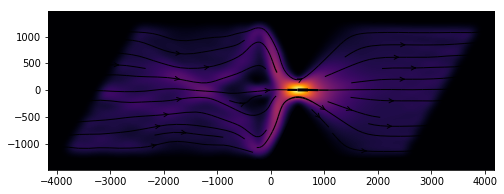

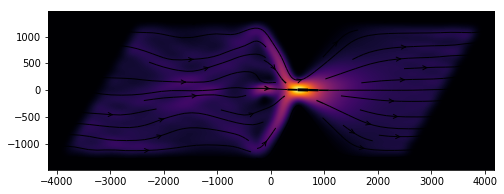

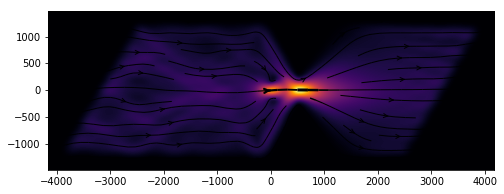

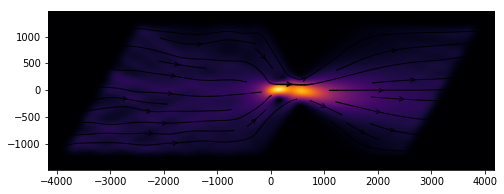

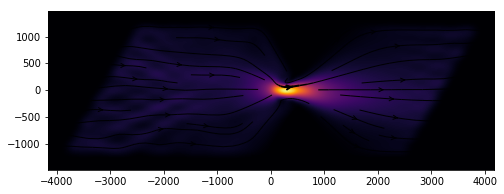

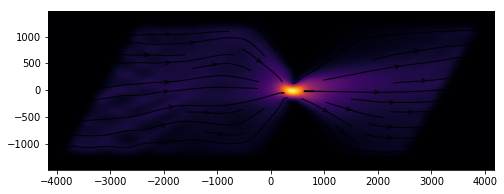

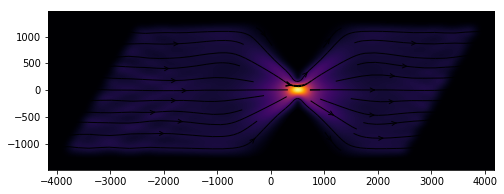

In [9]:
#######################   Plot Current density from left lead   #################
#xtips = np.linspace(0,-1000,4)
xtips = [-500, -375, -250, -125, 0, 125, 250, 375, 500]
ytip = 0
Rtip = 230    # Full width at half maximum (FWHM) of the potential distribution
Ef = 0.3
Vtip = 0.6
# Vtips = np.linspace(0,0.8,4)
# density:  n = (E/at)^2 * 8/(9*pi)

for m,xtip in enumerate(xtips):
# vals=[onsite(syst.sites[n],Vtip,xtip,ytip,Rtip) for n in range(syst.graph.num_nodes)]
# kwant.plotter.map(syst, vals)
# plt.show()
    wf = kwant.wave_function(syst, energy = Ef,params = dict(Vtip = Vtip,xtip=xtip,ytip=ytip,Rtip=Rtip))
    J0 = kwant.operator.Current(syst)
    wf_left = wf(0)
    current = sum(J0(p) for p in wf_left)

    kwant.plotter.current(syst, current, cmap='inferno')
    #plt.savefig('curr_w200.pdf', format = 'pdf')
    plt.show()

    A,B = kwant.plotter.interpolate_current(syst, current, relwidth=None, abswidth=None, n=9)
    t = np.shape(A)
          
    myfile = 'Jx_w120_'+ str(xtip) + '.txt'
    Jx = np.matrix(A[:,:,0])     
    with open(myfile,'wb') as f:
        for line in Jx:
            np.savetxt(f,line,fmt='%.6f')

    #myfile2 = 'Jy'+str(m)+'.txt'
    myfile2 = 'Jy_w120_'+ str(xtip)+'.txt'
    Jy = np.matrix(A[:,:,1])       
    with open(myfile2,'wb') as f2:
        for line in Jy:
            np.savetxt(f2,line,fmt='%.6f')
      

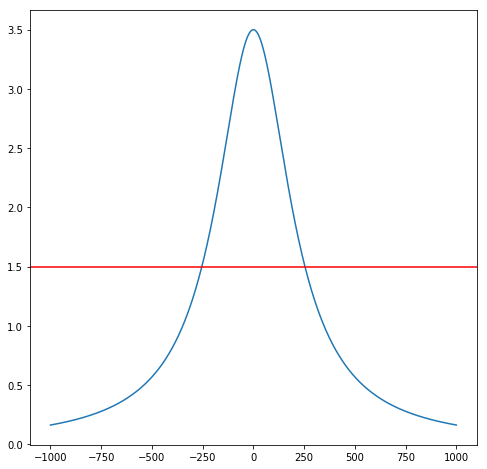

r_DP = 254.034118443


In [8]:
xtip = 0
Vtip = 3.5
Rtip = 220
x = linspace(-1000,1000,1000)
V = Vtip /(1+((x-xtip)**2/Rtip**2))
Ef = 1.5
rcParams['figure.figsize'] = 8,8
fig, ax = plt.subplots()
plt.plot(x,V)
plt.axhline(y=Ef, color='r')
plt.show()

if Vtip > Ef:
    r_DP = Rtip*sqrt(Vtip/Ef-1)
else:
    r_DP = 'NaN, Ef > Vtip'
print('r_DP =', r_DP)

In [11]:
a = 10e-9
E = np.array([0.5,1,1.5,1.9])
n = (E/a)**2 * 8/(9*pi)*1e-15


print(n)

[  0.7073553    2.82942121   6.36619772  10.21421057]
